# COMP 551 - Mini-project 4
Group 62

In [8]:
import keras
import numpy as np
%matplotlib inline                                 
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace  
import os

np.random.seed(1234)

In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/'
pathfig='/content/drive/My Drive/Colab Notebooks/COMP551_mini_proj4/figures'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MNIST Dataset

In [10]:
# from keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)

# vectorize
x_train = np.reshape(x_train, (-1, 784)).astype('float32')
print(x_train.shape)

# normalize
print('Intensity before normalization:', np.amin(x_train), np.amax(x_train))
x_train = x_train/255.0
print('Intensity after normalization:', np.amin(x_train), np.amax(x_train))

# subset 2500 instances
data_slice = 2500
X = x_train[:data_slice,:]
labels = y_train[:data_slice]
print(X.shape, labels.shape)

(60000, 28, 28) (60000,)
(60000, 784)
Intensity before normalization: 0.0 255.0
Intensity after normalization: 0.0 1.0
(2500, 784) (2500,)


## Code from the author

In [11]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 50:
            P = P / 4.

    # Return solution
    return Y

## t-SNE without early exaggeration

In [12]:
def tsne_noex(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    #X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    #P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        #if iter == 50:
            #P = P / 4.

    # Return solution
    return Y

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 3.884834
Iteration 20: error is 3.393094
Iteration 30: error is 2.930104
Iteration 40: error is 2.594200
Iteration 50: error is 2.369395
Iteration 60: error is 2.215050
Iteration 70: error is 2.098032
Iteration 80: error is 2.008131
Iteration 90: error is 1.936965
Iteration 100: error is 1.877986
Iteration 110: error is 1.826736
Iteration 120: error is 1.782515
Iteration 130: error is 1.744164
Iteration 140: error is 1.709358
Iteration 150: error is 1.678288
Iteration 160: error is 1.651866
Iteration 170: error is 1.627795
Iteration 180: error is 1.606666
Iteration 190: error is 1.588427
Iteration 200: error is 1.572238
Iteration 210: error is 1.557654
Iteration 220: error is 1.544391


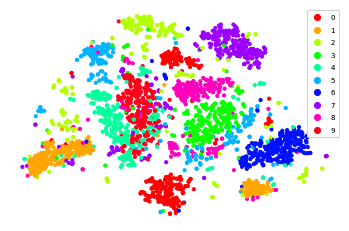

CPU times: user 8min 2s, sys: 1min 41s, total: 9min 44s
Wall time: 7min 48s


In [ ]:
%%time
Y = tsne_noex(X, 2, 30, 40)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,'tSNE_noex.png'))
plt.show()

## Trying with different values for early exaggeration and different time points

In the paper, they used an early exaggeration of 4 for the first 50 iterations. We can modify the intensity of early exaggeration and the number of iterations it is applied to.

In [13]:
def tsne_customex(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, exaggeration=4.0, exaggeration_iters=50):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    #X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * exaggeration									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 250:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == exaggeration_iters:
            P = P / exaggeration

    # Return solution
    return Y

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 8.932059
Iteration 20: error is 7.799070
Iteration 30: error is 2.664712
Iteration 40: error is 2.249741
Iteration 50: error is 2.015026
Iteration 60: error is 1.861982
Iteration 70: error is 1.751417
Iteration 80: error is 1.667917
Iteration 90: error is 1.602224
Iteration 100: error is 1.548494
Iteration 110: error is 1.503575
Iteration 120: error is 1.462632
Iteration 130: error is 1.429247
Iteration 140: error is 1.401986
Iteration 150: error is 1.378227
Iteration 160: error is 1.357156
Iteration 170: error is 1.338832
Iteration 180: error is 1.322401
Iteration 190: error is 1.307499
Iteration 200: error is 1.293932
Iteration 210: error is 1.281319
Iteration 220: error is 1.269858


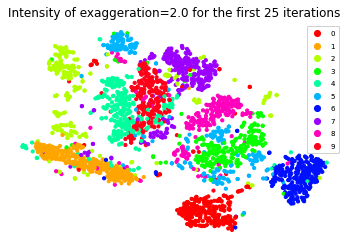

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 8.946280
Iteration 20: error is 7.951083
Iteration 30: error is 6.917513
Iteration 40: error is 6.316788
Iteration 50: error is 5.951515
Iteration 60: error is 2.036190
Iteration 70: error is 1.858086
Iteration 80: error is 1.733359
Iteration 90: error is 1.639399
Iteration 100: error is 1.565504
Iteration 110: error is 1.506234
Iteration 120: error is 1.457200
Iteration 130: error is 1.416490
Iteration 140: error is 1.382486
Iteration 150: error is 1.353376
Iteration 160: error is 1.328086
Iteration 170: error is 1.306067
Iteration 180: error is 1.287061
Iteration 190: error is 1.270211
Iteration 200: error is 1.255111
Iteration 210: error is 1.241588
Iteration 220: error is 1.229325


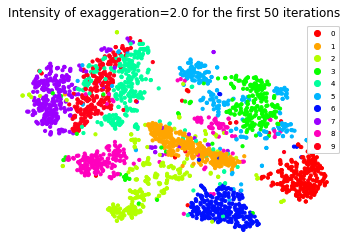

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 8.873006
Iteration 20: error is 7.558421
Iteration 30: error is 6.593088
Iteration 40: error is 6.043311
Iteration 50: error is 5.723193
Iteration 60: error is 5.535994
Iteration 70: error is 5.406111
Iteration 80: error is 5.308388
Iteration 90: error is 5.236390
Iteration 100: error is 5.177842
Iteration 110: error is 1.757597
Iteration 120: error is 1.656829
Iteration 130: error is 1.576625
Iteration 140: error is 1.511074
Iteration 150: error is 1.456794
Iteration 160: error is 1.411098
Iteration 170: error is 1.372381
Iteration 180: error is 1.339758
Iteration 190: error is 1.312152
Iteration 200: error is 1.288301
Iteration 210: error is 1.267319
Iteration 220: error is 1.248730


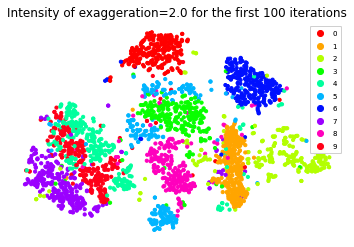

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 8.946901
Iteration 20: error is 7.706877
Iteration 30: error is 6.667096
Iteration 40: error is 6.136687
Iteration 50: error is 5.807595
Iteration 60: error is 5.613926
Iteration 70: error is 5.480264
Iteration 80: error is 5.383647
Iteration 90: error is 5.310850
Iteration 100: error is 5.253190
Iteration 110: error is 5.206848
Iteration 120: error is 5.169044
Iteration 130: error is 5.137221
Iteration 140: error is 5.110010
Iteration 150: error is 5.086597
Iteration 160: error is 5.066118
Iteration 170: error is 5.048146
Iteration 180: error is 5.032255
Iteration 190: error is 5.018196
Iteration 200: error is 5.005939
Iteration 210: error is 1.688397
Iteration 220: error is 1.614386


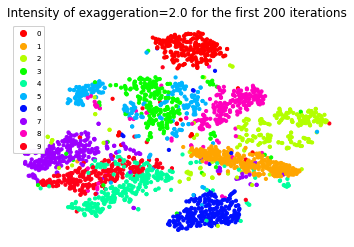

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 8.960149
Iteration 20: error is 7.882288
Iteration 30: error is 6.876772
Iteration 40: error is 6.301674
Iteration 50: error is 5.958097
Iteration 60: error is 5.741645
Iteration 70: error is 5.592782
Iteration 80: error is 5.486985
Iteration 90: error is 5.407522
Iteration 100: error is 5.344771
Iteration 110: error is 5.295981
Iteration 120: error is 5.256864
Iteration 130: error is 5.224715
Iteration 140: error is 5.197946
Iteration 150: error is 5.175510
Iteration 160: error is 5.156224
Iteration 170: error is 5.140355
Iteration 180: error is 5.126297
Iteration 190: error is 5.113762
Iteration 200: error is 5.102999
Iteration 210: error is 5.093462
Iteration 220: error is 5.085197


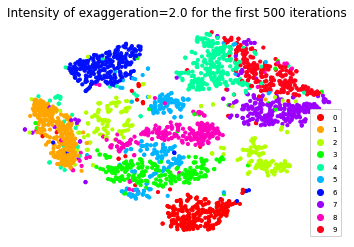

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 34.154013
Iteration 20: error is 32.462020
Iteration 30: error is 3.153266
Iteration 40: error is 2.482340
Iteration 50: error is 2.138890
Iteration 60: error is 1.924863
Iteration 70: error is 1.778121
Iteration 80: error is 1.669016
Iteration 90: error is 1.584475
Iteration 100: error is 1.517356
Iteration 110: error is 1.462880
Iteration 120: error is 1.417460
Iteration 130: error is 1.379366
Iteration 140: error is 1.347244
Iteration 150: error is 1.320069
Iteration 160: error is 1.296401
Iteration 170: error is 1.275557
Iteration 180: error is 1.257247
Iteration 190: error is 1.240961
Iteration 200: error is 1.226352
Iteration 210: error is 1.213162
Iteration 220: error is 1.20126

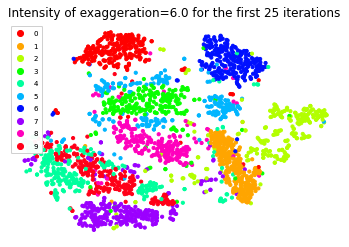

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 34.264527
Iteration 20: error is 32.862106
Iteration 30: error is 31.004479
Iteration 40: error is 30.697572
Iteration 50: error is 30.539303
Iteration 60: error is 2.732779
Iteration 70: error is 2.278911
Iteration 80: error is 2.016548
Iteration 90: error is 1.842247
Iteration 100: error is 1.715229
Iteration 110: error is 1.621026
Iteration 120: error is 1.547531
Iteration 130: error is 1.487823
Iteration 140: error is 1.437885
Iteration 150: error is 1.397040
Iteration 160: error is 1.363204
Iteration 170: error is 1.334460
Iteration 180: error is 1.309447
Iteration 190: error is 1.287468
Iteration 200: error is 1.268082
Iteration 210: error is 1.250837
Iteration 220: error is 1.23

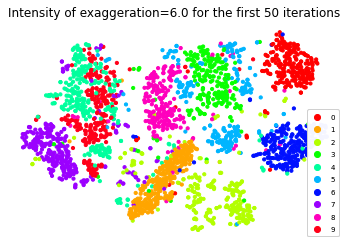

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 34.192311
Iteration 20: error is 32.520687
Iteration 30: error is 31.057675
Iteration 40: error is 30.747704
Iteration 50: error is 30.608426
Iteration 60: error is 30.557769
Iteration 70: error is 30.533427
Iteration 80: error is 30.521261
Iteration 90: error is 30.514946
Iteration 100: error is 30.511507
Iteration 110: error is 2.717964
Iteration 120: error is 2.265708
Iteration 130: error is 2.007828
Iteration 140: error is 1.837011
Iteration 150: error is 1.713760
Iteration 160: error is 1.620449
Iteration 170: error is 1.547282
Iteration 180: error is 1.488365
Iteration 190: error is 1.439686
Iteration 200: error is 1.399462
Iteration 210: error is 1.366066
Iteration 220: error is

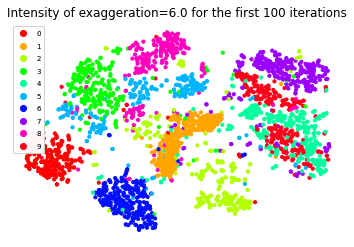

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 34.287448
Iteration 20: error is 33.010173
Iteration 30: error is 31.193920
Iteration 40: error is 30.882643
Iteration 50: error is 30.735352
Iteration 60: error is 30.680752
Iteration 70: error is 30.657896
Iteration 80: error is 30.644000
Iteration 90: error is 30.624190
Iteration 100: error is 30.580184
Iteration 110: error is 30.514693
Iteration 120: error is 30.466070
Iteration 130: error is 30.445115
Iteration 140: error is 30.437289
Iteration 150: error is 30.434165
Iteration 160: error is 30.432545
Iteration 170: error is 30.431487
Iteration 180: error is 30.430789
Iteration 190: error is 30.430338
Iteration 200: error is 30.430007
Iteration 210: error is 2.711697
Iteration 220

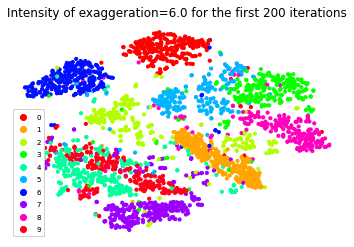

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 34.350970
Iteration 20: error is 33.186028
Iteration 30: error is 31.484009
Iteration 40: error is 30.866275
Iteration 50: error is 30.612512
Iteration 60: error is 30.529238
Iteration 70: error is 30.500154
Iteration 80: error is 30.487229
Iteration 90: error is 30.480290
Iteration 100: error is 30.475392
Iteration 110: error is 30.471212
Iteration 120: error is 30.468044
Iteration 130: error is 30.464501
Iteration 140: error is 30.461505
Iteration 150: error is 30.457805
Iteration 160: error is 30.454581
Iteration 170: error is 30.450349
Iteration 180: error is 30.445430
Iteration 190: error is 30.440068
Iteration 200: error is 30.431709
Iteration 210: error is 30.420696
Iteration 22

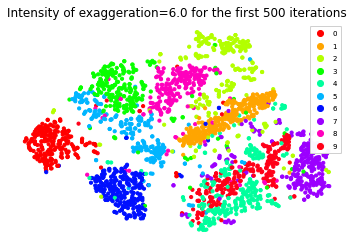

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 62.626329
Iteration 20: error is 62.434681
Iteration 30: error is 3.714301
Iteration 40: error is 2.867800
Iteration 50: error is 2.358657
Iteration 60: error is 2.073193
Iteration 70: error is 1.893773
Iteration 80: error is 1.765572
Iteration 90: error is 1.669632
Iteration 100: error is 1.594134
Iteration 110: error is 1.533518
Iteration 120: error is 1.483754
Iteration 130: error is 1.442537
Iteration 140: error is 1.408295
Iteration 150: error is 1.379168
Iteration 160: error is 1.353728
Iteration 170: error is 1.331201
Iteration 180: error is 1.311505
Iteration 190: error is 1.294077
Iteration 200: error is 1.278451
Iteration 210: error is 1.264389
Iteration 220: error is 1.25166

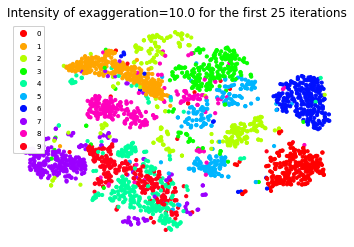

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 62.634550
Iteration 20: error is 62.497189
Iteration 30: error is 61.713473
Iteration 40: error is 60.971323
Iteration 50: error is 60.640609
Iteration 60: error is 3.158952
Iteration 70: error is 2.492297
Iteration 80: error is 2.148073
Iteration 90: error is 1.938952
Iteration 100: error is 1.792524
Iteration 110: error is 1.685232
Iteration 120: error is 1.602108
Iteration 130: error is 1.535175
Iteration 140: error is 1.481167
Iteration 150: error is 1.436672
Iteration 160: error is 1.399624
Iteration 170: error is 1.368487
Iteration 180: error is 1.341680
Iteration 190: error is 1.318061
Iteration 200: error is 1.296916
Iteration 210: error is 1.278330
Iteration 220: error is 1.26

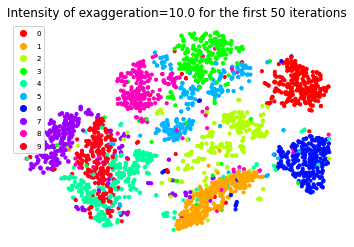

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 62.570690
Iteration 20: error is 62.113117
Iteration 30: error is 61.077561
Iteration 40: error is 60.684694
Iteration 50: error is 60.545137
Iteration 60: error is 60.507135
Iteration 70: error is 60.496412
Iteration 80: error is 60.494368
Iteration 90: error is 60.492322
Iteration 100: error is 60.489992
Iteration 110: error is 3.182441
Iteration 120: error is 2.496201
Iteration 130: error is 2.152907
Iteration 140: error is 1.941388
Iteration 150: error is 1.794393
Iteration 160: error is 1.685154
Iteration 170: error is 1.600761
Iteration 180: error is 1.533666
Iteration 190: error is 1.479008
Iteration 200: error is 1.433391
Iteration 210: error is 1.395925
Iteration 220: error is

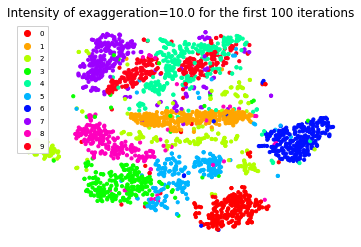

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 62.680508
Iteration 20: error is 62.532621
Iteration 30: error is 61.686649
Iteration 40: error is 60.909448
Iteration 50: error is 60.573561
Iteration 60: error is 60.459768
Iteration 70: error is 60.406963
Iteration 80: error is 60.374318
Iteration 90: error is 60.355781
Iteration 100: error is 60.342292
Iteration 110: error is 60.335062
Iteration 120: error is 60.330844
Iteration 130: error is 60.328076
Iteration 140: error is 60.326562
Iteration 150: error is 60.326119
Iteration 160: error is 60.324362
Iteration 170: error is 60.324912
Iteration 180: error is 60.323227
Iteration 190: error is 60.324336
Iteration 200: error is 60.323142
Iteration 210: error is 3.236053
Iteration 220

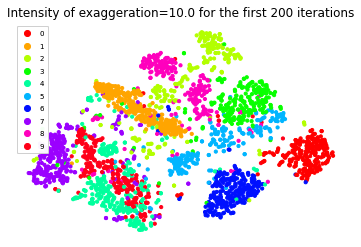

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 62.619181
Iteration 20: error is 62.408455
Iteration 30: error is 61.610783
Iteration 40: error is 60.845268
Iteration 50: error is 60.524926
Iteration 60: error is 60.425545
Iteration 70: error is 60.395232
Iteration 80: error is 60.385607
Iteration 90: error is 60.375241
Iteration 100: error is 60.369115
Iteration 110: error is 60.360422
Iteration 120: error is 60.355271
Iteration 130: error is 60.349275
Iteration 140: error is 60.345982
Iteration 150: error is 60.342257
Iteration 160: error is 60.342183
Iteration 170: error is 60.339872
Iteration 180: error is 60.338419
Iteration 190: error is 60.336150
Iteration 200: error is 60.336312
Iteration 210: error is 60.334521
Iteration 22

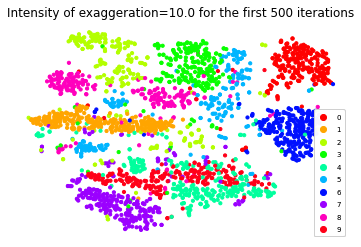

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 224.206702
Iteration 20: error is 221.927037
Iteration 30: error is 4.037566
Iteration 40: error is 3.894560
Iteration 50: error is 3.154970
Iteration 60: error is 2.606345
Iteration 70: error is 2.276898
Iteration 80: error is 2.072126
Iteration 90: error is 1.926166
Iteration 100: error is 1.821298
Iteration 110: error is 1.737999
Iteration 120: error is 1.674783
Iteration 130: error is 1.621923
Iteration 140: error is 1.579140
Iteration 150: error is 1.543448
Iteration 160: error is 1.511322
Iteration 170: error is 1.484597
Iteration 180: error is 1.461002
Iteration 190: error is 1.440696
Iteration 200: error is 1.422625
Iteration 210: error is 1.406526
Iteration 220: error is 1.392

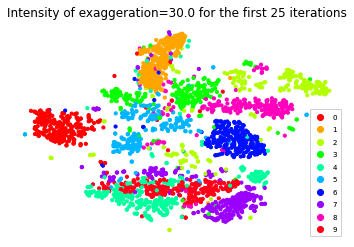

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 223.658250
Iteration 20: error is 222.061232
Iteration 30: error is 221.360902
Iteration 40: error is 221.111264
Iteration 50: error is 221.100809
Iteration 60: error is 3.965485
Iteration 70: error is 3.649951
Iteration 80: error is 2.795913
Iteration 90: error is 2.347194
Iteration 100: error is 2.089118
Iteration 110: error is 1.920090
Iteration 120: error is 1.797880
Iteration 130: error is 1.705279
Iteration 140: error is 1.634334
Iteration 150: error is 1.577473
Iteration 160: error is 1.530778
Iteration 170: error is 1.491147
Iteration 180: error is 1.457901
Iteration 190: error is 1.428940
Iteration 200: error is 1.404083
Iteration 210: error is 1.382068
Iteration 220: error is

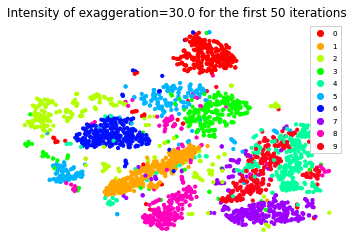

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 223.667007
Iteration 20: error is 222.072098
Iteration 30: error is 221.424333
Iteration 40: error is 221.239225
Iteration 50: error is 221.104930
Iteration 60: error is 221.055342
Iteration 70: error is 221.036670
Iteration 80: error is 221.053004
Iteration 90: error is 221.048576
Iteration 100: error is 221.042134
Iteration 110: error is 3.965954
Iteration 120: error is 3.765190
Iteration 130: error is 2.847006
Iteration 140: error is 2.349523
Iteration 150: error is 2.071031
Iteration 160: error is 1.889591
Iteration 170: error is 1.759635
Iteration 180: error is 1.662315
Iteration 190: error is 1.586782
Iteration 200: error is 1.526131
Iteration 210: error is 1.478130
Iteration 220

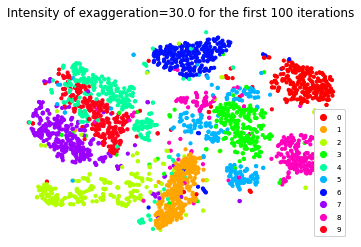

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 223.773051
Iteration 20: error is 221.822262
Iteration 30: error is 221.313265
Iteration 40: error is 221.252458
Iteration 50: error is 221.254054
Iteration 60: error is 221.098998
Iteration 70: error is 221.070670
Iteration 80: error is 221.059080
Iteration 90: error is 221.070612
Iteration 100: error is 221.044226
Iteration 110: error is 221.054065
Iteration 120: error is 221.046378
Iteration 130: error is 221.059200
Iteration 140: error is 221.049496
Iteration 150: error is 221.046782
Iteration 160: error is 221.038403
Iteration 170: error is 221.041976
Iteration 180: error is 221.040786
Iteration 190: error is 221.053322
Iteration 200: error is 221.037915
Iteration 210: error is 3.

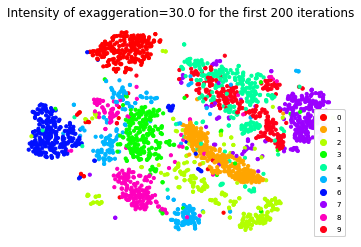

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 223.613729
Iteration 20: error is 222.215986
Iteration 30: error is 221.592578
Iteration 40: error is 221.258124
Iteration 50: error is 221.281579
Iteration 60: error is 221.169203
Iteration 70: error is 221.129227
Iteration 80: error is 221.075842
Iteration 90: error is 221.059203
Iteration 100: error is 221.063325
Iteration 110: error is 221.058155
Iteration 120: error is 221.059767
Iteration 130: error is 221.055886
Iteration 140: error is 221.063678
Iteration 150: error is 221.048359
Iteration 160: error is 221.050601
Iteration 170: error is 221.057692
Iteration 180: error is 221.060219
Iteration 190: error is 221.060076
Iteration 200: error is 221.046541
Iteration 210: error is 22

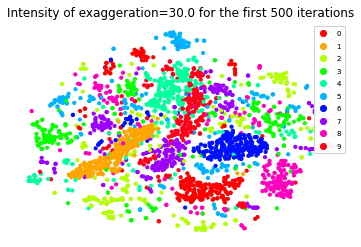

In [ ]:
ex = [2.0,6.0,10.0,30.0]
n_iters = [25,50,100,200,500]

for e in ex:
  for n in n_iters:
    Y = tsne_customex(X, no_dims=2, initial_dims=30, perplexity=40.0, exaggeration=e, exaggeration_iters=n)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.title('Intensity of exaggeration='+str(e)+' for the first '+str(n)+' iterations')
    plt.savefig(os.path.join(pathfig,('tSNE_'+str(e)+'ex_'+str(n)+'iters.png')))
    plt.show()

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 21.065856
Iteration 20: error is 19.520791
Iteration 30: error is 2.951191
Iteration 40: error is 2.364206
Iteration 50: error is 2.074682
Iteration 60: error is 1.890318
Iteration 70: error is 1.760908
Iteration 80: error is 1.664370
Iteration 90: error is 1.589186
Iteration 100: error is 1.528566
Iteration 110: error is 1.478956
Iteration 120: error is 1.438082
Iteration 130: error is 1.404128
Iteration 140: error is 1.374894
Iteration 150: error is 1.349434
Iteration 160: error is 1.327112
Iteration 170: error is 1.307327
Iteration 180: error is 1.289618
Iteration 190: error is 1.273980
Iteration 200: error is 1.259990
Iteration 210: error is 1.247348
Iteration 220: error is 1.23574

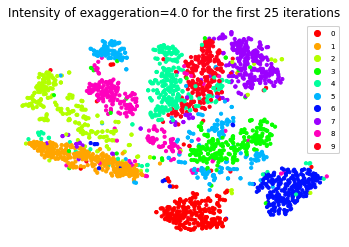

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 21.115816
Iteration 20: error is 19.758355
Iteration 30: error is 17.954392
Iteration 40: error is 17.353970
Iteration 50: error is 17.028918
Iteration 60: error is 2.420847
Iteration 70: error is 2.092270
Iteration 80: error is 1.892327
Iteration 90: error is 1.752916
Iteration 100: error is 1.649363
Iteration 110: error is 1.569307
Iteration 120: error is 1.505102
Iteration 130: error is 1.452830
Iteration 140: error is 1.409580
Iteration 150: error is 1.373856
Iteration 160: error is 1.344152
Iteration 170: error is 1.318369
Iteration 180: error is 1.295560
Iteration 190: error is 1.275390
Iteration 200: error is 1.257730
Iteration 210: error is 1.242053
Iteration 220: error is 1.22

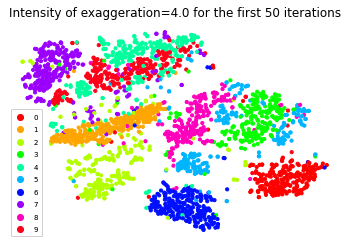

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 20.890240
Iteration 20: error is 18.858915
Iteration 30: error is 17.544229
Iteration 40: error is 17.140807
Iteration 50: error is 16.908545
Iteration 60: error is 16.756579
Iteration 70: error is 16.664593
Iteration 80: error is 16.613078
Iteration 90: error is 16.583341
Iteration 100: error is 16.565131
Iteration 110: error is 2.382682
Iteration 120: error is 2.078945
Iteration 130: error is 1.887305
Iteration 140: error is 1.751516
Iteration 150: error is 1.649718
Iteration 160: error is 1.570333
Iteration 170: error is 1.506557
Iteration 180: error is 1.454132
Iteration 190: error is 1.410585
Iteration 200: error is 1.374423
Iteration 210: error is 1.344142
Iteration 220: error is

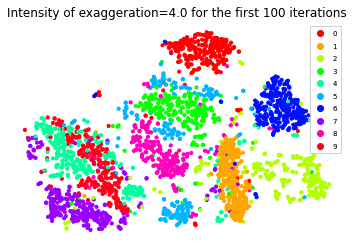

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 21.086035
Iteration 20: error is 19.343426
Iteration 30: error is 17.745885
Iteration 40: error is 17.190430
Iteration 50: error is 16.933451
Iteration 60: error is 16.799011
Iteration 70: error is 16.723698
Iteration 80: error is 16.678108
Iteration 90: error is 16.649647
Iteration 100: error is 16.631302
Iteration 110: error is 16.619395
Iteration 120: error is 16.611543
Iteration 130: error is 16.606245
Iteration 140: error is 16.602760
Iteration 150: error is 16.600419
Iteration 160: error is 16.598970
Iteration 170: error is 16.597982
Iteration 180: error is 16.597388
Iteration 190: error is 16.597000
Iteration 200: error is 16.596808
Iteration 210: error is 2.394775
Iteration 220

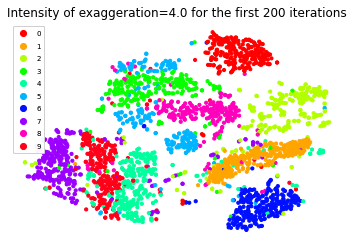

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 21.113788
Iteration 20: error is 19.805611
Iteration 30: error is 18.192516
Iteration 40: error is 17.415043
Iteration 50: error is 17.065456
Iteration 60: error is 16.869363
Iteration 70: error is 16.759039
Iteration 80: error is 16.694152
Iteration 90: error is 16.655359
Iteration 100: error is 16.632742
Iteration 110: error is 16.619235
Iteration 120: error is 16.611187
Iteration 130: error is 16.606650
Iteration 140: error is 16.603849
Iteration 150: error is 16.602192
Iteration 160: error is 16.601742
Iteration 170: error is 16.601478
Iteration 180: error is 16.601405
Iteration 190: error is 16.601511
Iteration 200: error is 16.601778
Iteration 210: error is 16.601997
Iteration 22

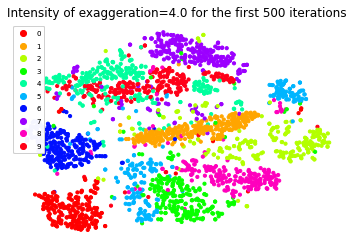

In [14]:
ex = [4.0]
n_iters = [25,50,100,200,500]

for e in ex:
  for n in n_iters:
    Y = tsne_customex(X, no_dims=2, initial_dims=30, perplexity=40.0, exaggeration=e, exaggeration_iters=n)
    fig, ax = plt.subplots()
    scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
    plt.axis('off')
    legend = ax.legend(*scatter.legend_elements(), fontsize=7)
    ax.add_artist(legend)
    plt.title('Intensity of exaggeration='+str(e)+' for the first '+str(n)+' iterations')
    plt.savefig(os.path.join(pathfig,('tSNE_'+str(e)+'ex_'+str(n)+'iters.png')))
    plt.show()

Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.498596
Iteration 10: error is 20.956063
Iteration 20: error is 18.929459
Iteration 30: error is 17.513256
Iteration 40: error is 17.080266
Iteration 50: error is 16.822736
Iteration 60: error is 16.695587
Iteration 70: error is 16.618051
Iteration 80: error is 16.569524
Iteration 90: error is 16.536898
Iteration 100: error is 16.514054
Iteration 110: error is 16.497533
Iteration 120: error is 16.485587
Iteration 130: error is 16.477015
Iteration 140: error is 16.470704
Iteration 150: error is 16.466451
Iteration 160: error is 16.463496
Iteration 170: error is 16.461552
Iteration 180: error is 16.460316
Iteration 190: error is 16.459583
Iteration 200: error is 16.459351
Iteration 210: error is 2.371951
Iteration 220

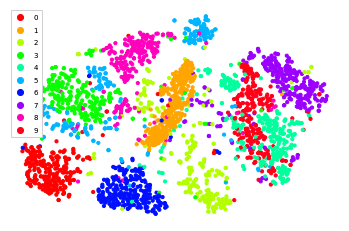

CPU times: user 7min 56s, sys: 1min 46s, total: 9min 43s
Wall time: 7min 43s


In [17]:
%%time
Y = tsne_customex(X, no_dims=2, initial_dims=50, perplexity=40.0, exaggeration=4.0, exaggeration_iters=200)
fig, ax = plt.subplots()
scatter = ax.scatter(Y[:, 0], Y[:, 1], s=10, c=labels, cmap='hsv')
plt.axis('off')
legend = ax.legend(*scatter.legend_elements(), fontsize=7)
ax.add_artist(legend)
plt.savefig(os.path.join(pathfig,('tSNE_ex4_iter200_perp30_PC50.png')))
plt.show()